In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib 
#import swifter
from scipy import stats
import pandahouse
%matplotlib inline

In [80]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230320'
}

### AB тест

In [81]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-03-02' and '2023-03-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group')['user_id'].nunique()

exp_group
1    10079
2     9952
Name: user_id, dtype: int64

### График распределения CTR по группам

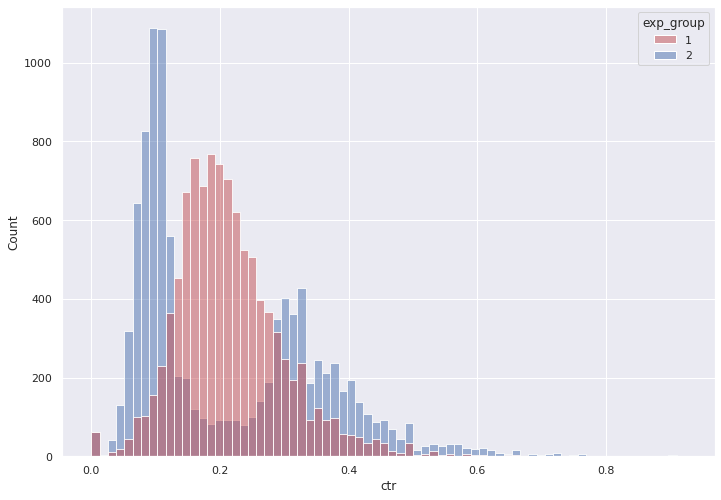

In [82]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Выборки различаются по распределения: группа 2 имеет бимодальное распеределение в котором CTR пользователей сконцентрированы в ~ 0,1 и ~0,3. В группе 1 же CTR сконцентрированы в значении ~0,2

### Взглянем на CTR без сглаживания

In [83]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-03-02' and '2023-03-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

global_ctr_1 = df.query('exp_group==1').likes.sum()/df.query('exp_group==1').views.sum()
global_ctr_2 = df.query('exp_group==2').likes.sum()/df.query('exp_group==2').views.sum()

group1 = df.query('exp_group==1').copy()
group2 = df.query('exp_group==2').copy()

In [84]:
stats.ttest_ind(group1['ctr'],
               group2['ctr'],
               equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

По несглаженному CTR t-test выдает результат о не статзначимых различиях

### Сгладим CTR и применим t-test

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='smothed_ctr'>

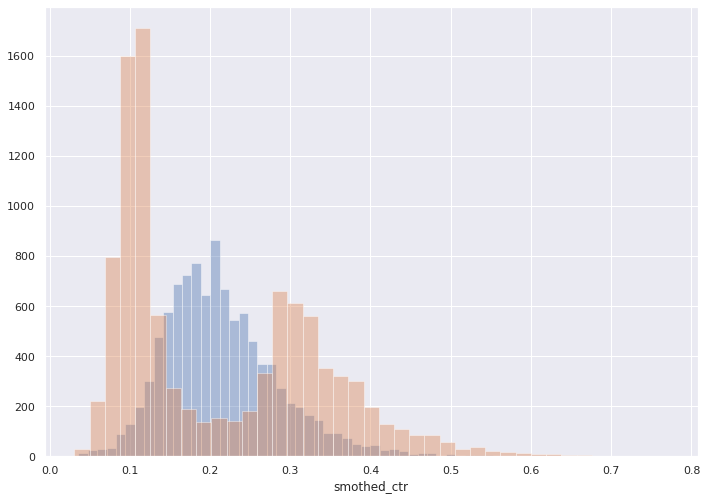

In [85]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)
sns.distplot(group1.smothed_ctr, 
             kde = False)
sns.distplot(group2.smothed_ctr, 
             kde = False)

In [88]:
p_val = stats.ttest_ind(group1['smothed_ctr'],
               group2['smothed_ctr'],
               equal_var=False)[1]
if p_val < 0.05:
    print('pvalue < 0.05. Отвергаем нулевую гипотезу')
else:
    print('pvalue >= 0.05. Не получилось отвергнуть нулевую гипотезу')

pvalue < 0.05. Отвергаем нулевую гипотезу


Между CTR групп 1 и 2 выявлены стат значимые различия.

### Пуассоновский бутстреп для подсчета разницы в CTR

<AxesSubplot:ylabel='Count'>

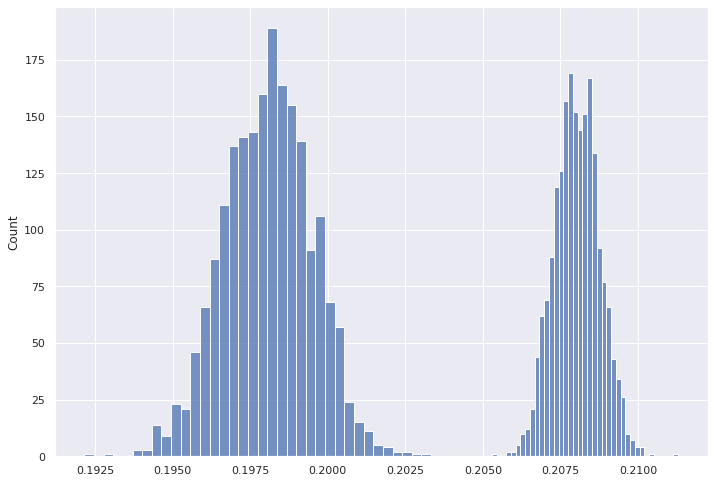

In [63]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-03-02' and '2023-03-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

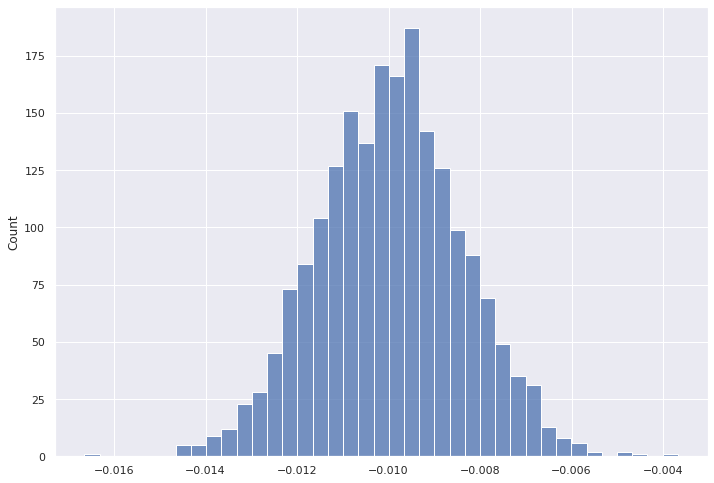

In [64]:
sns.histplot(ctr2 - ctr1)

т.к. результат получился отрицательным, можем считать, что группа 2 показала худшие результаты по CTR, чем группа 1

### Вывод

Если взглянуть на CTR тестовой выборки, то можно четко вдитеть бимодальность распределения – полдьзователи разбились на 2 группы, значения CTR которых сконцентрировались вокруг 0,1 и 0,3. Похоже на то, что новый алгоритм рекомендаций отталкивает одну часть пользователей и привлекает другую, что соответственно сказывается на повышенном и пониженном CTR. Возможно имеет место некорректное проведение теста и к нам в группу попали пользователи другой тестовой группы, что визуально отразилось на графике одним из значений, вокруг которого сконцентрировались CTR пользователей. Но какой результат показал наш тестируемый алгоритм рекомендаций постов мы сказать не можем. 